# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 11

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from hw5code import find_best_split
from hw5code import DecisionTree
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')


## 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

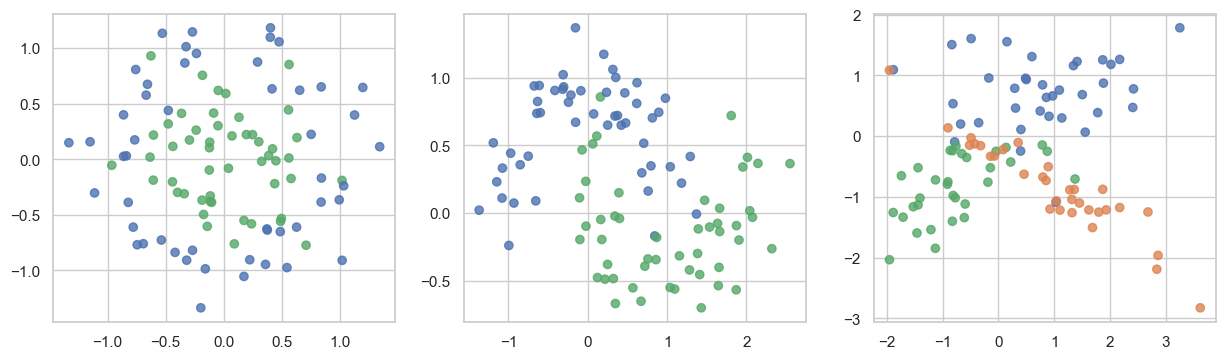

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

### __Задание 1. (1 балл)__



Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

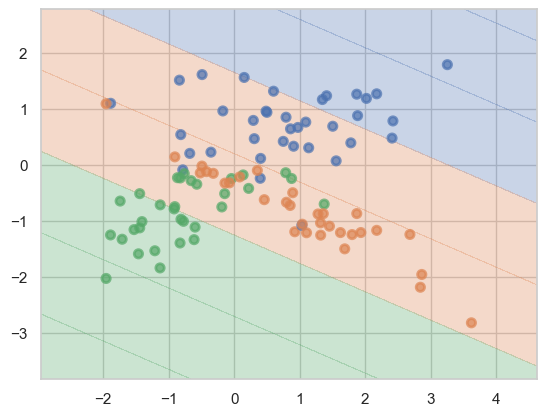

In [7]:
# Пример:
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [8]:
def print_scores_and_plot_surfaces(max_death: int | None = None, min_samples_split: float | int = 2,
                                    min_samples_leaf: float | int = 1, min_weight_fraction_leaf: float = 0) -> None:
    plt.figure(figsize=(15, 4))
    for i, dataset in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.25, random_state=4)

        dectree = DecisionTreeClassifier(max_depth=max_death, min_samples_split=min_samples_split, 
                                         min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, 
                                         random_state=13)
        dectree.fit(X_train, y_train)

        plt.subplot(1, 3, i + 1)
        plot_surface(dectree, X_train, y_train)

        print(f'Train score on {i + 1} dataset = {accuracy_score(dectree.predict(X_train), y_train)}')
        print(f'Test score on {i + 1} dataset = {accuracy_score(dectree.predict(X_test), y_test)}')
        print('---------------')

Train score on 1 dataset = 1.0
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 1.0
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 1.0
Test score on 3 dataset = 0.8
---------------


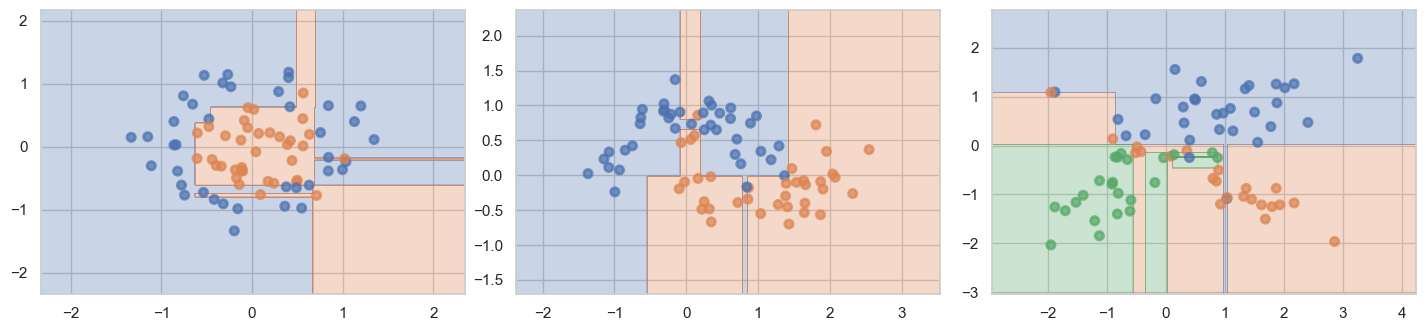

In [9]:
print_scores_and_plot_surfaces()

__Ответ:__ Да, деревья переобучились сильно. Такой вывод можно сделать исходя из того, что во всех случаях модель достигла $accuracy = 1.0$ на обучающей выборке.

### __Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

#### ```max_depth```

Самый примитивный способ регуляризации - ограничение грубины дерева. Дефолтное значение - inf

Train score on 1 dataset = 1.0
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 1.0
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 0.9866666666666667
Test score on 3 dataset = 0.76
---------------


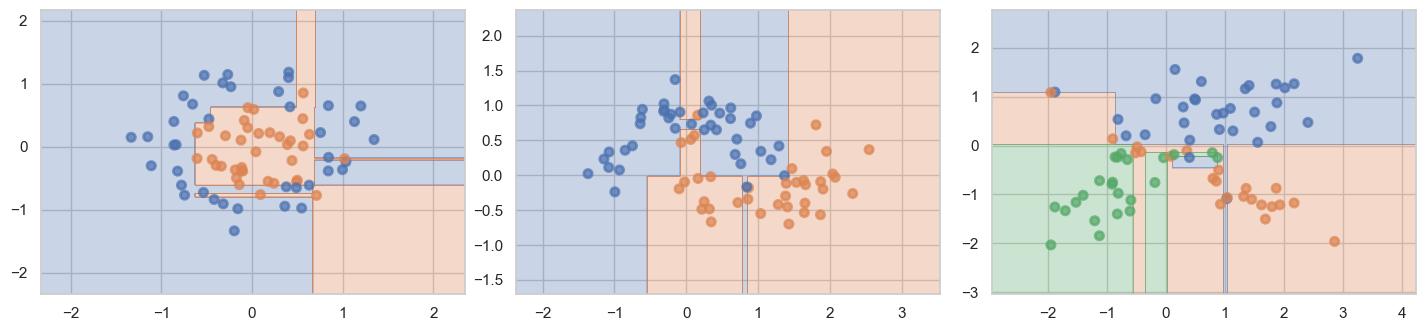

In [10]:
print_scores_and_plot_surfaces(max_death=9)

Train score on 1 dataset = 0.96
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 0.9866666666666667
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 0.9466666666666667
Test score on 3 dataset = 0.76
---------------


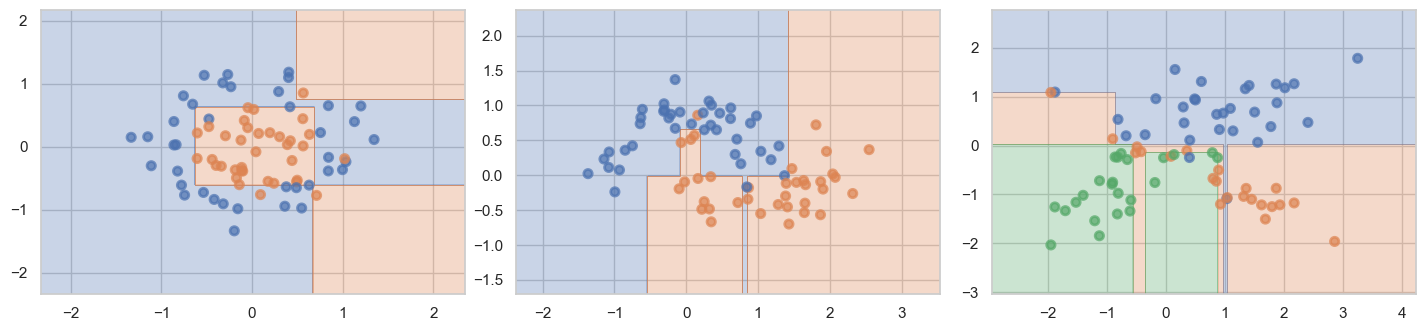

In [11]:
print_scores_and_plot_surfaces(max_death=5)

Train score on 1 dataset = 0.8533333333333334
Test score on 1 dataset = 0.8
---------------
Train score on 2 dataset = 0.9333333333333333
Test score on 2 dataset = 0.88
---------------
Train score on 3 dataset = 0.9066666666666666
Test score on 3 dataset = 0.84
---------------


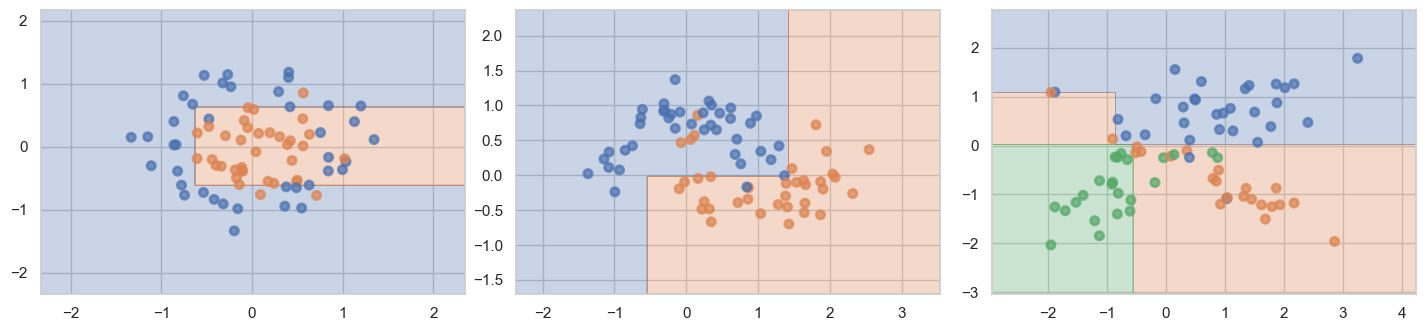

In [12]:
print_scores_and_plot_surfaces(max_death=3)

Train score on 1 dataset = 0.7466666666666667
Test score on 1 dataset = 0.6
---------------
Train score on 2 dataset = 0.9333333333333333
Test score on 2 dataset = 0.88
---------------
Train score on 3 dataset = 0.8933333333333333
Test score on 3 dataset = 0.84
---------------


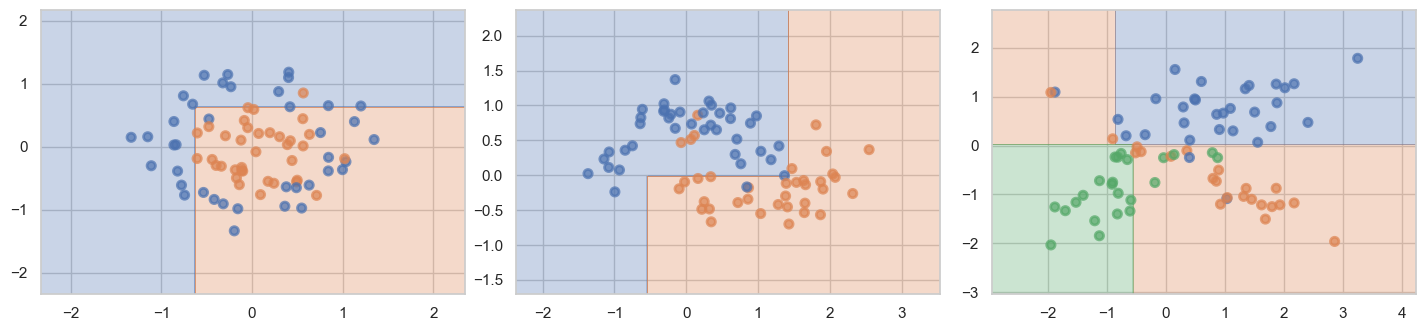

In [13]:
print_scores_and_plot_surfaces(max_death=2)

Train score on 1 dataset = 0.6266666666666667
Test score on 1 dataset = 0.6
---------------
Train score on 2 dataset = 0.8533333333333334
Test score on 2 dataset = 0.76
---------------
Train score on 3 dataset = 0.68
Test score on 3 dataset = 0.56
---------------


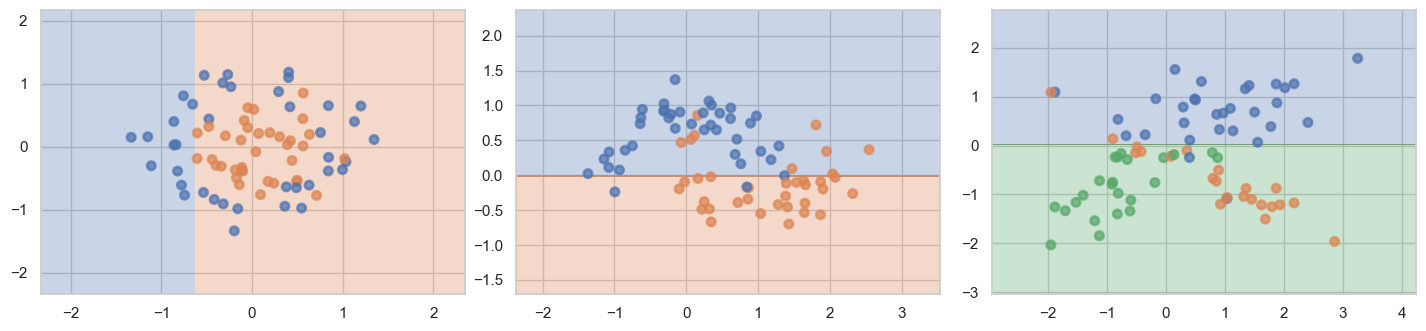

In [14]:
print_scores_and_plot_surfaces(max_death=1)

**Выводы:**

1. В силу того, что данные во-втором датасете распределены очень однообразно регуляризация только ухудшила качество

2. На датасетах 1 и 3 явно видно, что уменьшение максимальной глубины привело к улучшению качества. С 0.76 до 0.8 в первом и с 0.8 до 0.84 во втором случаях соответственно.

3. Очень интересно смотреть как цвета все лучше и лучше покрывают точки.

#### ```min_samples_split```

Минимальное количество точек, которые должны попать в вершину, чтобы мы захотели продолжить ее двумя листами. Дефолтное значение = 2.

Train score on 1 dataset = 1.0
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 1.0
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 1.0
Test score on 3 dataset = 0.8
---------------


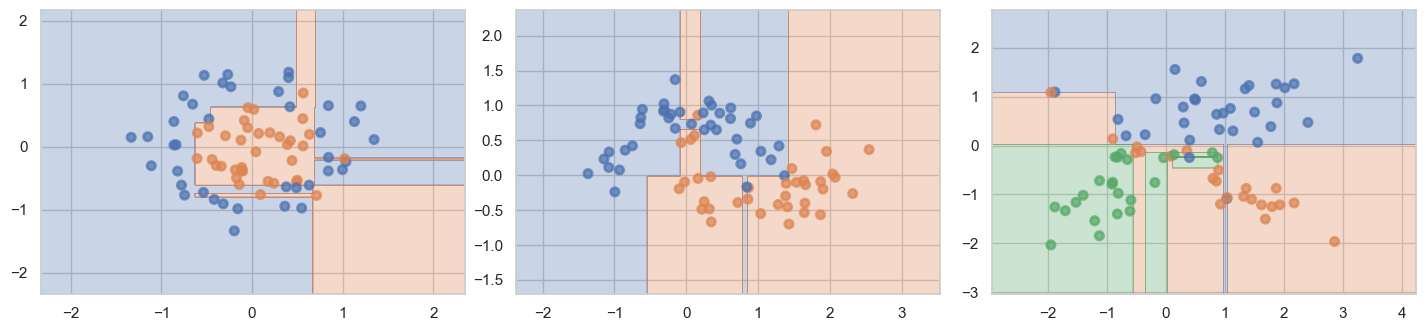

In [15]:
print_scores_and_plot_surfaces(min_samples_split=2)

Train score on 1 dataset = 0.9866666666666667
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 0.9866666666666667
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 0.96
Test score on 3 dataset = 0.76
---------------


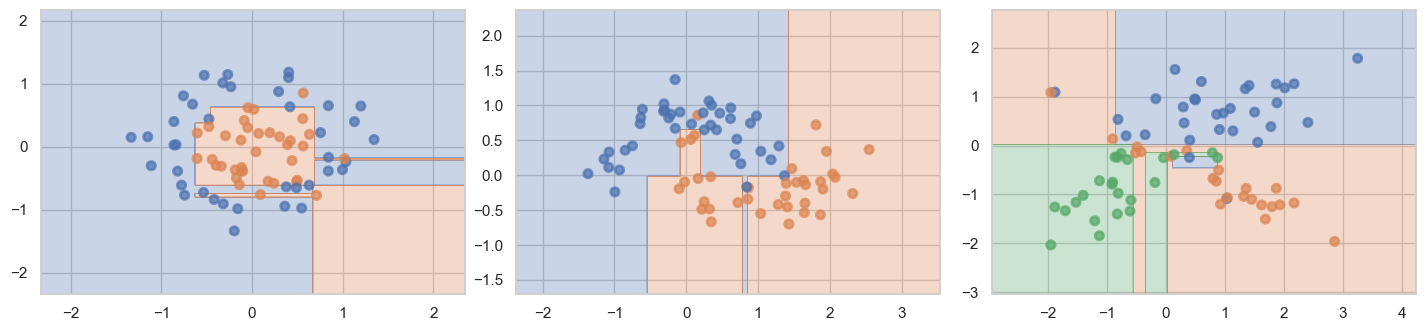

In [16]:
print_scores_and_plot_surfaces(min_samples_split=4)

Train score on 1 dataset = 0.9466666666666667
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 0.9866666666666667
Test score on 2 dataset = 0.92
---------------


Train score on 3 dataset = 0.9466666666666667
Test score on 3 dataset = 0.8
---------------


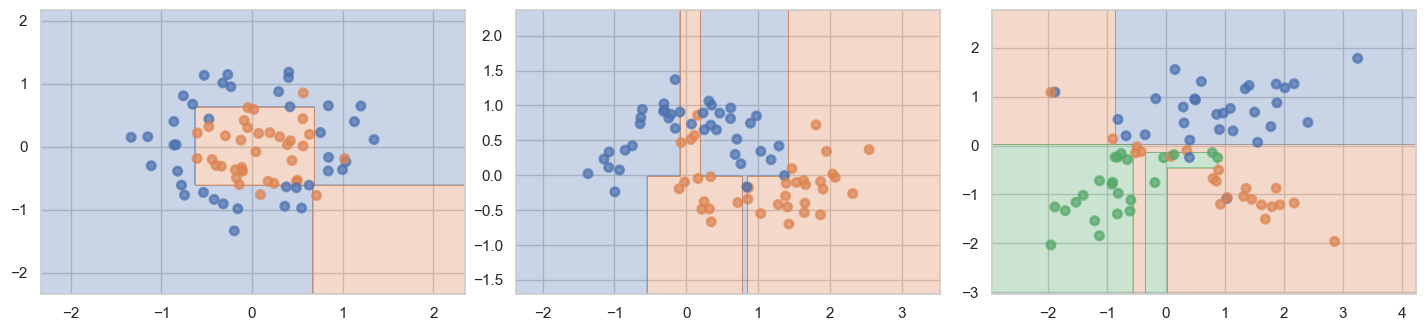

In [17]:
print_scores_and_plot_surfaces(min_samples_split=7)

Train score on 1 dataset = 0.9333333333333333
Test score on 1 dataset = 0.8
---------------
Train score on 2 dataset = 0.9733333333333334
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 0.8933333333333333
Test score on 3 dataset = 0.84
---------------


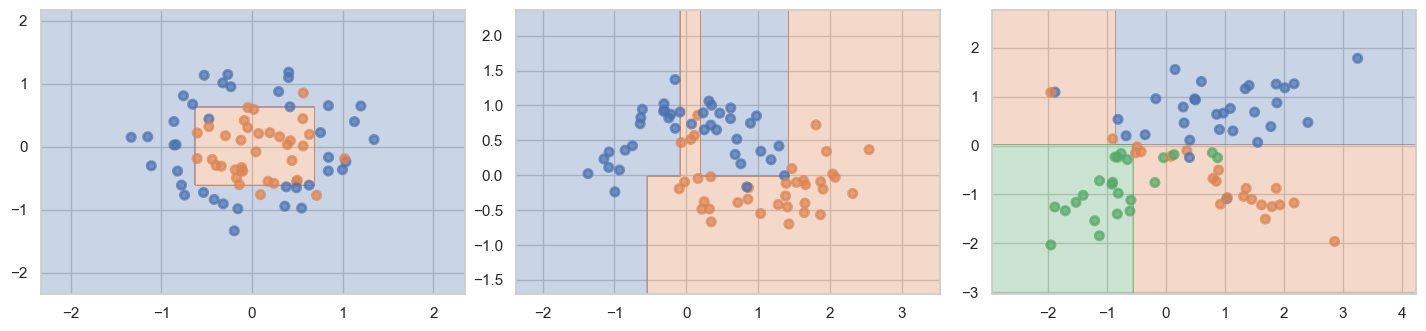

In [18]:
print_scores_and_plot_surfaces(min_samples_split=15)

Train score on 1 dataset = 0.9333333333333333
Test score on 1 dataset = 0.8
---------------
Train score on 2 dataset = 0.92
Test score on 2 dataset = 0.88
---------------
Train score on 3 dataset = 0.8933333333333333
Test score on 3 dataset = 0.84
---------------


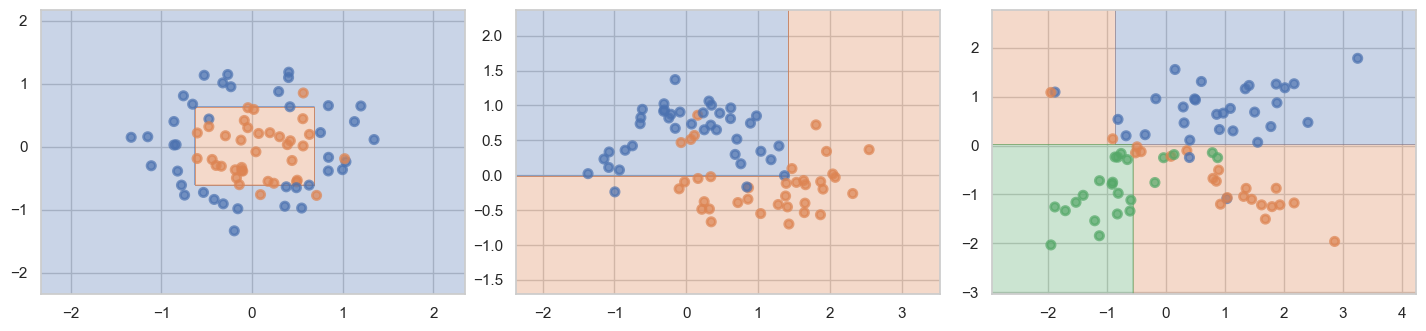

In [19]:
print_scores_and_plot_surfaces(min_samples_split=30)

Train score on 1 dataset = 0.52
Test score on 1 dataset = 0.44
---------------
Train score on 2 dataset = 0.52
Test score on 2 dataset = 0.44
---------------
Train score on 3 dataset = 0.4
Test score on 3 dataset = 0.24
---------------


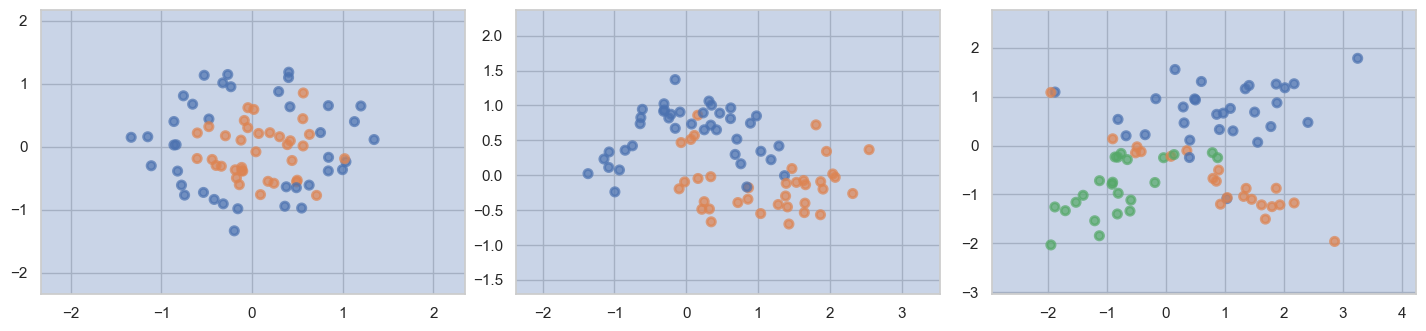

In [20]:
print_scores_and_plot_surfaces(min_samples_split=100)

**Вывод:** 

1. Изменение этого параметра тоже помогает в регуляризации. Удалось добиться таких же результатов как и при изменении максимальной глубины.

#### ```min_samples_leaf```

Делим вершину на 2 (создаем 2 новых листа под ней), когда в каждом из них окажется хотя бы по min_sample_leaf объектов тренировочной выборки.

Train score on 1 dataset = 1.0
Test score on 1 dataset = 0.76
---------------
Train score on 2 dataset = 1.0
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 1.0
Test score on 3 dataset = 0.8
---------------


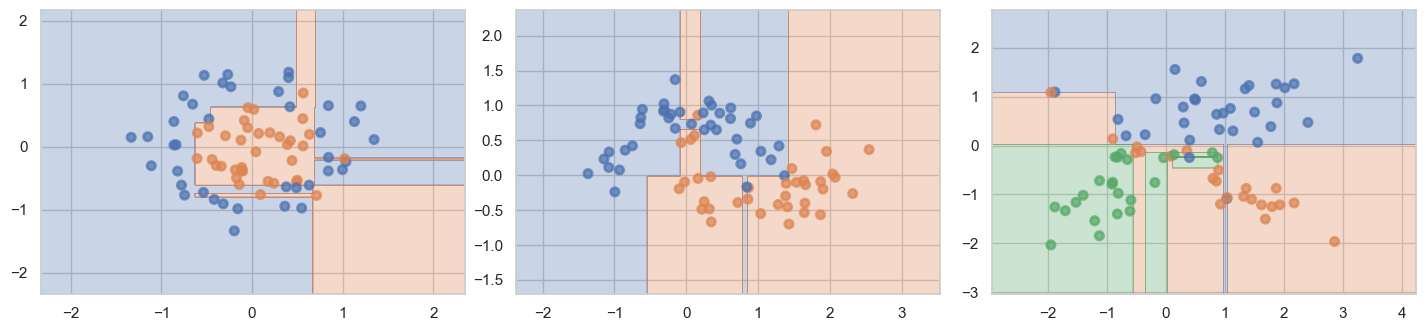

In [21]:
print_scores_and_plot_surfaces(min_samples_leaf=1)

Train score on 1 dataset = 0.9466666666666667
Test score on 1 dataset = 0.8
---------------
Train score on 2 dataset = 0.96
Test score on 2 dataset = 0.92
---------------
Train score on 3 dataset = 0.92
Test score on 3 dataset = 0.84
---------------


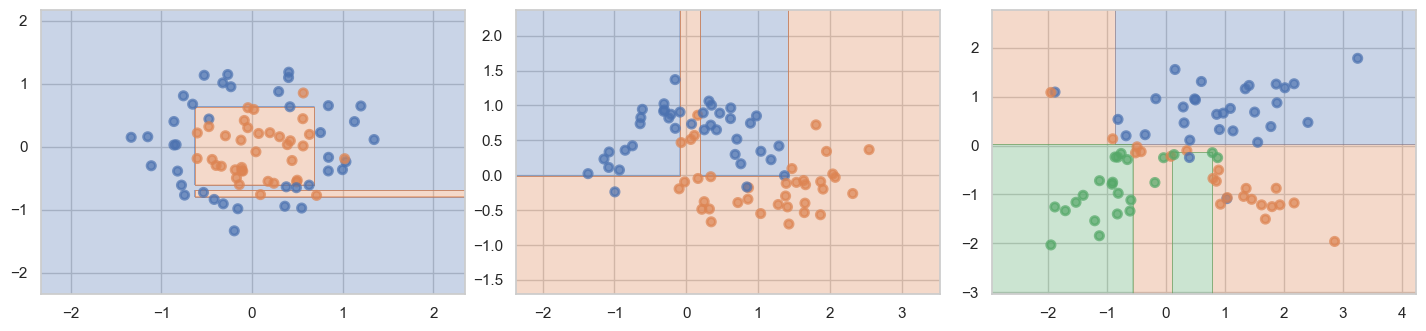

In [22]:
print_scores_and_plot_surfaces(min_samples_leaf=3)

Train score on 1 dataset = 0.9066666666666666
Test score on 1 dataset = 0.8
---------------
Train score on 2 dataset = 0.8533333333333334
Test score on 2 dataset = 0.76
---------------
Train score on 3 dataset = 0.88
Test score on 3 dataset = 0.84
---------------


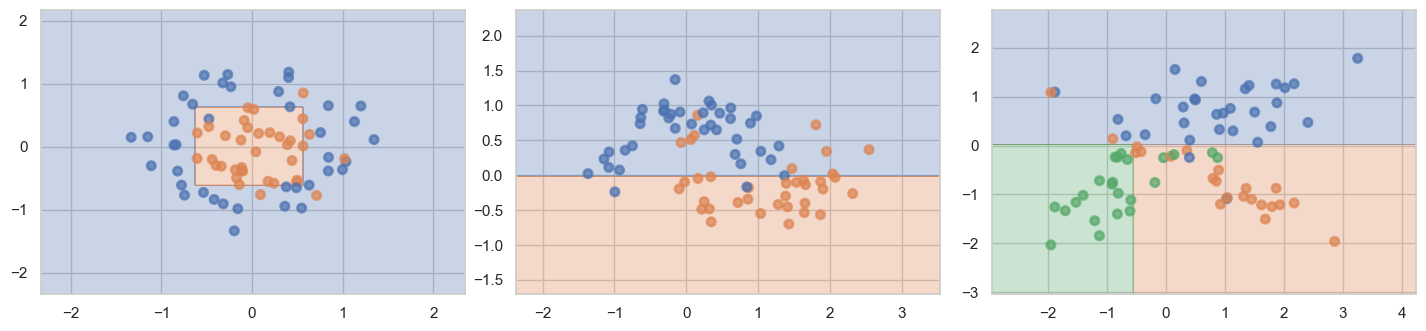

In [23]:
print_scores_and_plot_surfaces(min_samples_leaf=10)

Train score on 1 dataset = 0.7333333333333333
Test score on 1 dataset = 0.6
---------------
Train score on 2 dataset = 0.8533333333333334
Test score on 2 dataset = 0.76
---------------
Train score on 3 dataset = 0.8666666666666667
Test score on 3 dataset = 0.76
---------------


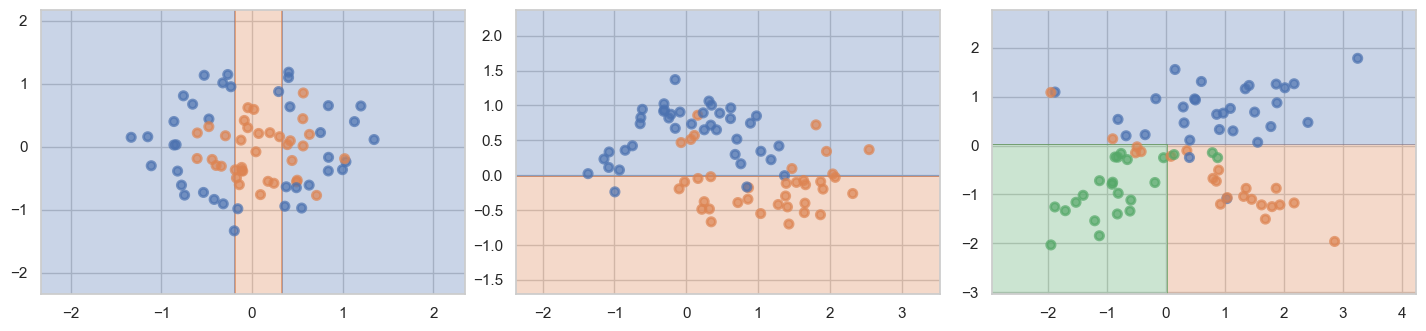

In [24]:
print_scores_and_plot_surfaces(min_samples_leaf=20)

__Ответ:__

1. Разделяющая поверхность становиться тем примитивнее, чем более сильную регуляризацию мы применяем.

2. На хоть немного сложных датасетах(1 и 3) регуляризация способствует улучшению качества. На 2 такого эффекта не наблюдалось, предположительно потому, что там и изначально было довольно хорошее качество.

3. Регуляризация помогает, потому что наша модель очень сильно подстраивается под обучающие данные. Каждый лист начинает отвечать за один объект на обучающей выборке, в следствии чего модель теряет свою обобщающую способность. Регуляризация же возврощает модели ее обобщающую способность.

## 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

### __Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

Окнувшаяся посылка

https://contest.yandex.ru/contest/56884/run-report/102001314/

ник Борис Панфилов

### __Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [25]:
data = pd.read_csv('students.csv')

In [26]:
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


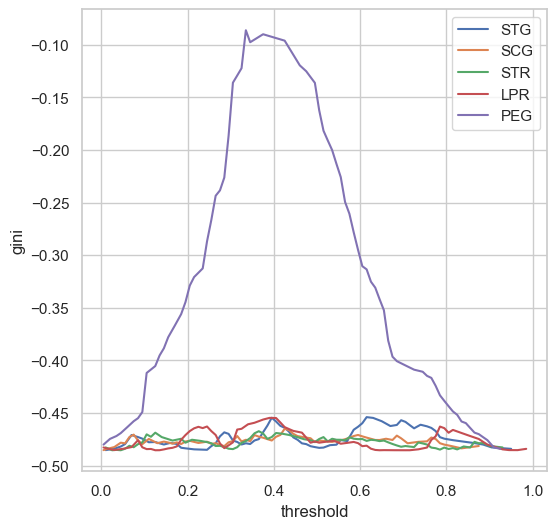

In [27]:
plt.figure(figsize=(6, 6))
for name in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    thresholds, ginis, _, _ = find_best_split(data[name], data['UNS'])
    plt.plot(thresholds, ginis, label=name)
plt.ylabel('gini')
plt.xlabel('threshold')
plt.legend()
plt.show()


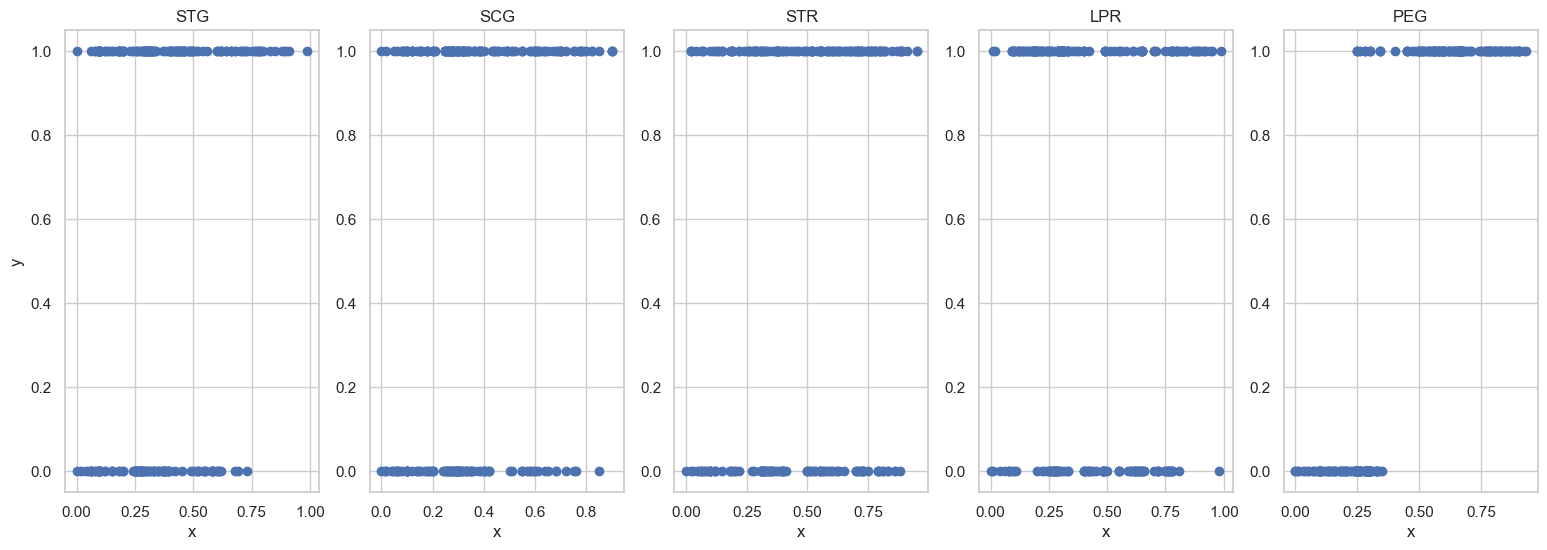

In [28]:
plt.figure(figsize=(19, 6))
for i, name in enumerate(['STG', 'SCG', 'STR', 'LPR', 'PEG']):
    plt.subplot(1, 5, i + 1)
    plt.scatter(x=data[name], y=data['UNS'])
    plt.title(name)
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
plt.show()

### __Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Деление нужно производить по признаку PEG. Этот результат согласуется с визуальной оценкой scatter-графиков, потому что на графике у PEG совсем хорошо видна граница между первым и нулевым классами. Кривые хороших признаков поднимаются в небеса, в то время как остальные кривые нет. Это связано с тем, что чем выше точка на графике, тем больше значение индекса джини в этой точке. У кривых же, которые относятся к неудобным для деления признакам, все точки находятся примерно на одном уровне, для которого характерно низкое значение индекса джини.


### __Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Окнувшаяся посылка 

https://contest.yandex.ru/contest/56884/run-report/102033024/

ник Борис Панфилов

### __Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [29]:
data = pd.read_csv('data/agaricus-lepiota.data')

In [30]:
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
X, y = data.drop('p', axis=1), data['p']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)

tree = DecisionTree(['real'] * data.shape[1])
tree.fit(X_train.values, y_train.values)

print(f'Test accuracy = {accuracy_score(tree.predict(X_test.values), y_test.values)}')


Test accuracy = 1.0


In [31]:
def inorder(tree, dectree, depths, cur_depth):
    if 'left_child' in tree:
        inorder(tree['left_child'], dectree, depths, cur_depth + 1)
        del tree['left_child']
    
    rc = None
    if 'right_child' in tree:
        rc = tree['right_child']
        del tree['right_child']
    
    dectree.append(tree)
    depths.append(cur_depth)

    if rc is not None:
        inorder(rc, dectree, depths, cur_depth + 1)

In [32]:
dectree = []
depths = []
inorder(tree._tree, dectree, depths, 0)
print(f'количество вершин = {len(dectree)}')
print(f'глубина = {max(depths)}')

количество вершин = 35
глубина = 7


**Вывод:** Дерево и правда получилось не очень глубокое. Думаю accuracy равное 1 является признаком того, что данный датасет довольно простой и нашему дереву даже не удалось переобучиться.

### __Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [50]:
data = pd.read_csv('data/tic-tac-toe-endgame.csv')

In [52]:
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
X, y = data.drop('V10', axis=1), data['V10']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.5, random_state=4)

tree = DecisionTree(['categorical'] * X_train.shape[1])
tree.fit(X_train, y_train)

print(f'Train accuracy = {accuracy_score(tree.predict(X_train), y_train)}')
print(f'Test accuracy = {accuracy_score(tree.predict(X_test), y_test)}')

Train accuracy = 1.0
Test accuracy = 0.9394572025052192


In [53]:
def get_learning_result(use_sklearn = False, max_depth = None, min_samples_split=2, min_samples_leaf=1):
    if use_sklearn:
        tree = DecisionTreeClassifier(max_depth = max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)

        return accuracy_score(tree.predict(X_test), y_test)
    else:
        tree = DecisionTree(['categorical'] * X_train.shape[1], 
                            max_depth = max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)

        return accuracy_score(tree.predict(X_test), y_test)

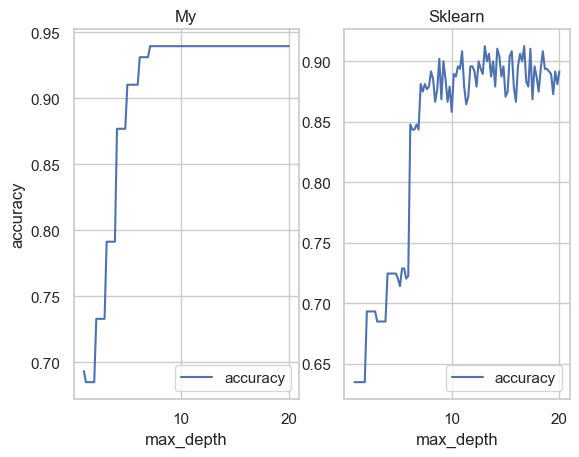

In [54]:
depths = np.linspace(1, 20, 100)
my_results = [get_learning_result(max_depth=depth) for depth in depths]
sklearn_results = [get_learning_result(True, max_depth=int(depth)) for depth in depths]

plt.subplot(1, 2, 1)
plt.plot(depths, my_results, label='accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.title('My')

plt.subplot(1, 2, 2)
plt.plot(depths, sklearn_results, label='accuracy')

plt.legend()
plt.xlabel('max_depth')
plt.title('Sklearn')

plt.show()

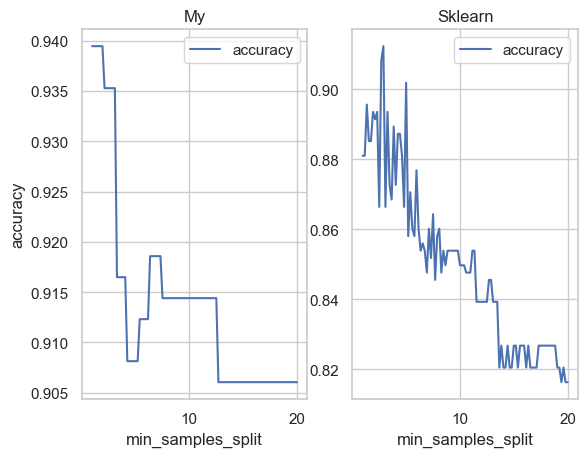

In [55]:
nums = np.linspace(2, 20, 100)
my_results = [get_learning_result(min_samples_split=num) for num in nums]
sklearn_results = [get_learning_result(True, min_samples_split=int(num)) for num in nums]

plt.subplot(1, 2, 1)
plt.plot(depths, my_results, label='accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('min_samples_split')
plt.title('My')


plt.subplot(1, 2, 2)
plt.plot(depths, sklearn_results, label='accuracy')

plt.legend()
plt.xlabel('min_samples_split')
plt.title('Sklearn')
plt.show()

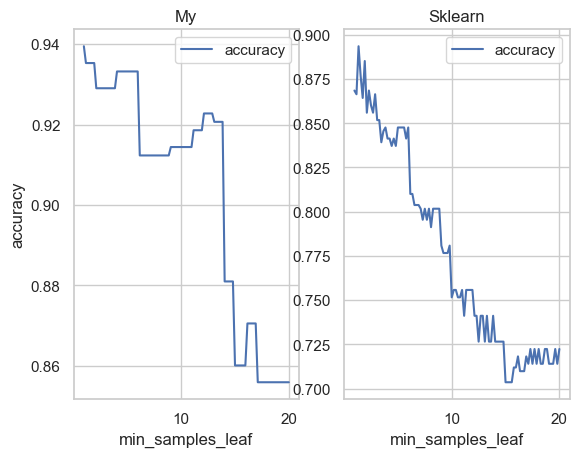

In [56]:
nums = np.linspace(1, 20, 100)
my_results = [get_learning_result(min_samples_leaf=num) for num in nums]
sklearn_results = [get_learning_result(True, min_samples_leaf=int(num)) for num in nums]

plt.subplot(1, 2, 1)
plt.plot(depths, my_results, label='accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('min_samples_leaf')
plt.title('My')

plt.subplot(1, 2, 2)
plt.plot(depths, sklearn_results, label='accuracy')

plt.legend()
plt.xlabel('min_samples_leaf')
plt.title('Sklearn')
plt.show()

**Вывод:** получилось довольно похоже на то, что делает sklearn. По accuracy я даже переиграл его.

### __Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. 

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [66]:
def learning(X, y) -> list[float]:

    # first    
    tree = DecisionTree(['real'] * X.shape[1])
    scores = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score))
    first_acc = scores.mean()

    # second
    tree = DecisionTree(['categorical'] * X.shape[1])
    scores = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score))
    second_acc = scores.mean()

    # third
    ohe = OneHotEncoder(sparse_output=False)
    ohe_X = ohe.fit_transform(X)
    tree = DecisionTree(['real'] * ohe_X.shape[1])
    scores = cross_val_score(tree, ohe_X, y, cv=10, scoring=make_scorer(accuracy_score))
    third_acc = scores.mean()

    # fourth
    tree = DecisionTreeClassifier()
    scores = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score))
    fourth_acc = scores.mean()

    return first_acc, second_acc, third_acc, fourth_acc

def diff_datasets_testing(datasets) -> pd.DataFrame:
    ans = {'real': [], 'cat' : [], 'ohe + real' : [], 'sklearn': []}
    
    for X, y in datasets:
        results = learning(X, y)
        ans['real'].append(results[0])
        ans['cat'].append(results[1])
        ans['ohe + real'].append(results[2])
        ans['sklearn'].append(results[3])

    df = pd.DataFrame(ans)
    # Переименование строк
    new_index = {0: 'mushrooms', 1: 'tic-tac-toe', 2: 'cars', 3: 'nursery'}
    df.rename(index=new_index, inplace=True)

    return df

In [58]:
datasets = []

In [59]:
data_mushrooms = pd.read_csv('data/agaricus-lepiota.data')
for col in data_mushrooms.columns:
    le = LabelEncoder()
    data_mushrooms[col] = le.fit_transform(data_mushrooms[col])
X, y = data_mushrooms.drop('p', axis=1), data_mushrooms['p']
datasets.append([X.values, y.values])

In [60]:
data_ttt = pd.read_csv('data/tic-tac-toe-endgame.csv')
for col in data_ttt.columns:
    le = LabelEncoder()
    data_ttt[col] = le.fit_transform(data_ttt[col])
X, y = data_ttt.drop('V10', axis=1), data_ttt['V10']
datasets.append([X.values, y.values])

In [61]:
data_cars = pd.read_csv('data/car.data')
# unacc, acc — это класс 0, good, vgood — класс 1
dct = {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
y = data_cars.iloc[:, -1].map(dct)
for col in data_cars.columns:
    le = LabelEncoder()
    data_cars[col] = le.fit_transform(data_cars[col])
X = data_cars.iloc[:, :-1]
datasets.append([X.values, y.values])

In [62]:
data_nursery = pd.read_csv('data/nursery.data')
# not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1
dct = {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
y = data_nursery.iloc[:, -1].map(dct)
for col in data_nursery.columns:
    le = LabelEncoder()
    data_nursery[col] = le.fit_transform(data_nursery[col])
X = data_nursery.iloc[:, :-1]
datasets.append([X.values, y.values])

In [72]:
diff_datasets_testing(datasets=datasets)

,real,cat,ohe + real,sklearn
mushrooms,0.999261,1.000000,0.999631,0.958290
tic-tac-toe,0.467533,0.541458,0.543575,0.764386
cars,0.942600,0.967519,0.921767,0.944952
nursery,0.999846,0.999923,0.999769,0.999846


In [73]:
diff_datasets_testing(datasets=datasets)

,real,cat,ohe + real,sklearn
mushrooms,0.999261,1.000000,0.999631,0.962723
tic-tac-toe,0.467533,0.541458,0.543575,0.793575
cars,0.942600,0.967519,0.921767,0.944371
nursery,0.999846,0.999923,0.999769,0.999846


In [74]:
diff_datasets_testing(datasets=datasets)


,real,cat,ohe + real,sklearn
mushrooms,0.999261,1.000000,0.999631,0.958290
tic-tac-toe,0.467533,0.541458,0.543575,0.749814
cars,0.942600,0.967519,0.921767,0.944952
nursery,0.999846,0.999923,0.999769,0.999846


### __Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1. Нет, для разных наборов данных алгоритмы ранжируются по-разному. Например на датасете mushrooms наилучшее качество показал второй алгоритм, а на датасете tic-tac-toe - четвертый. Такое может происходить потому, что при представлении признаков в разном виде мы получаем различные деревья. Поэтому в результатах видна заметная разница. Так же могу предположить, что разный порядок ранжирования может быть связан со сложностью датасета. Можно заметить, что на простых датасетах лучше справляется алгоритм, рассматривающий все признаки как категориальные, а вот на сложных побеждает алгоритм из sklearn.

2. Случайность есть только в деревьях из sklearn (видно на 3 запусках выше, что результаты остальных моделей не меняются). Как мы уже поняли при написании своего дерева, бывают ситуации, когда различные разбиения одинаково хороши (показывают одинаково хороший прирост информации). В таком случае лучшее разбиение в библиотечных деревьях выбирается случайным образом. На эту случайность можно повлиять, тем самым улучшив работу алгоритма построения дерева. Кажется, что будет логично по валидационной выборке смотреть какое из разбиений лучше, используя тот же критерий информативности, и делать выбор в пользу лучшего разбиения. Думаю, что так не делают на практике, потому что такие случаи возникают нечасто и хранить ради этого валидационную выборку нерезонно.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

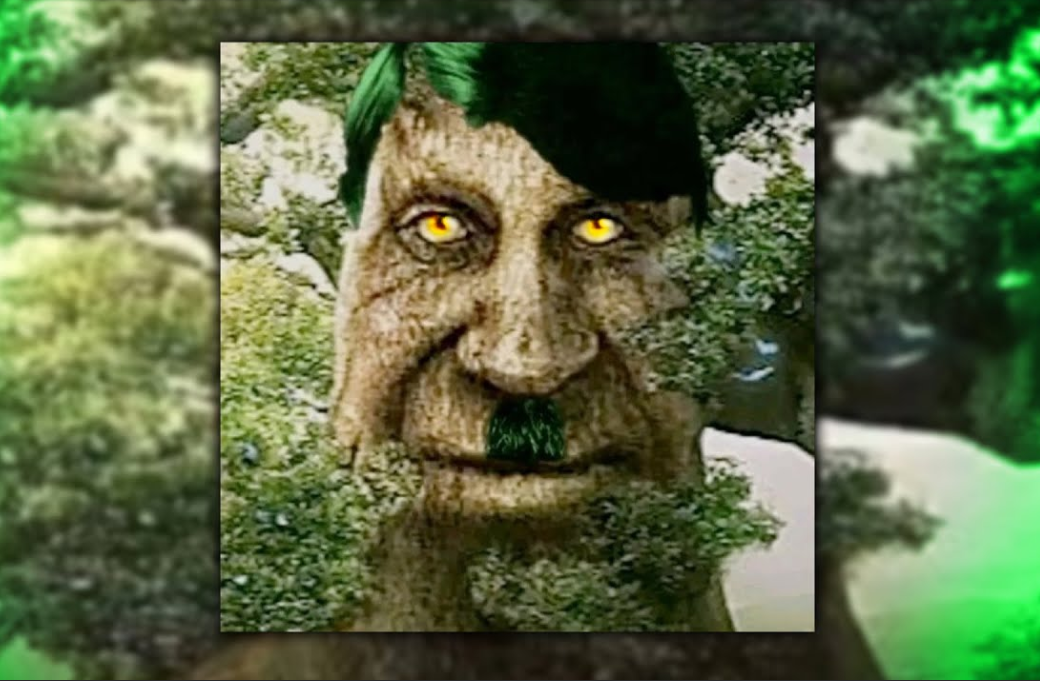